**Обрати внимание на данные, по фичам сегодняшним фичам прогнозируешь завтрашние данные**

1) GridSearch to Tune Parameters
<br> 2) what about Lasso?

In [1]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [2]:
dt=pd.read_excel('raw_data_shifted_data.xlsx',sheet_name='raw_data_changed')

In [3]:
dt.head(5)

,Date,US10YR,SPX,JPY,GOLD,GBP,AUD,CAD,OIL,MXWO,GABI,GABIHY,VIX
0,2009-02-06,2.8403,867.75,89.92,927.85,1.2813,0.6375,1.2296,45.88,838.83,351.900,1413.102,44.84
1,2009-02-13,2.9917,820.00,91.90,911.50,1.2940,0.6753,1.2193,46.21,870.74,350.346,1386.344,43.37
2,2009-02-20,2.8894,769.50,91.93,941.70,1.2862,0.6568,1.2354,44.81,837.02,348.868,1407.818,42.93
3,2009-02-27,2.7879,734.25,93.35,992.90,1.2826,0.6454,1.2520,41.89,772.84,364.816,1453.929,49.30
4,2009-03-06,3.0131,687.75,97.58,942.32,1.2669,0.6390,1.2763,46.35,750.86,363.345,1494.040,46.35


In [4]:
dt['Date'] = pd.to_datetime(dt['Date'])
dt = dt.set_index('Date')

In [5]:
dt.head(5)

,US10YR,SPX,JPY,GOLD,GBP,AUD,CAD,OIL,MXWO,GABI,GABIHY,VIX
Date,,,,,,,,,,,,
2009-02-06,2.8403,867.75,89.92,927.85,1.2813,0.6375,1.2296,45.88,838.83,351.900,1413.102,44.84
2009-02-13,2.9917,820.00,91.90,911.50,1.2940,0.6753,1.2193,46.21,870.74,350.346,1386.344,43.37
2009-02-20,2.8894,769.50,91.93,941.70,1.2862,0.6568,1.2354,44.81,837.02,348.868,1407.818,42.93
2009-02-27,2.7879,734.25,93.35,992.90,1.2826,0.6454,1.2520,41.89,772.84,364.816,1453.929,49.30
2009-03-06,3.0131,687.75,97.58,942.32,1.2669,0.6390,1.2763,46.35,750.86,363.345,1494.040,46.35


In [6]:
y=dt['SPX']
X=dt.iloc[:,dt.columns!='SPX']

In [7]:
X_train=X.iloc[:510,:]
y_train=y[:510]

X_test=X.iloc[510:,:]
y_test=y[510:]

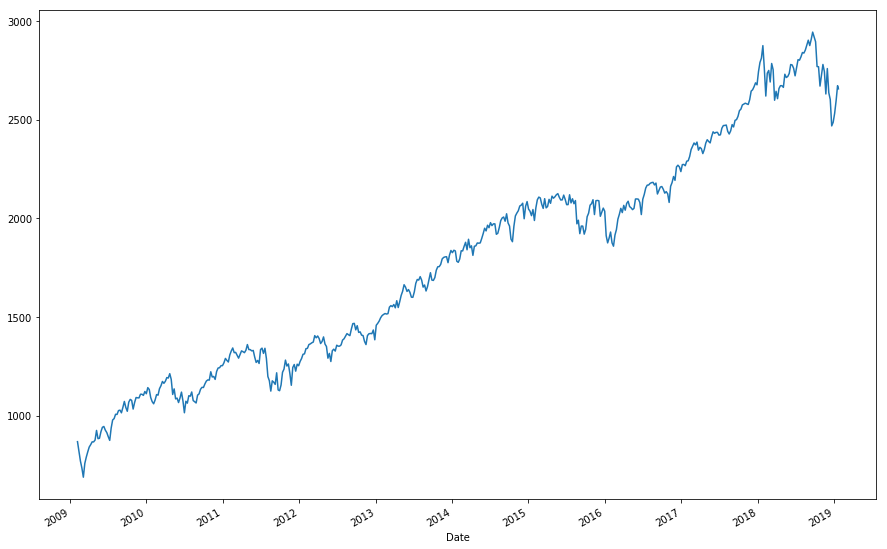

In [8]:
y.plot(figsize=(15,10))

                                        Without Parameters tuning

In [9]:
gbm = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)

In [10]:
predictions = gbm.predict(X_test)

In [12]:
np.sqrt(mean_squared_error(y_test,predictions))

101.33897436305836

In [ ]:
pred=pd.Series(predictions, index=y_test.index)

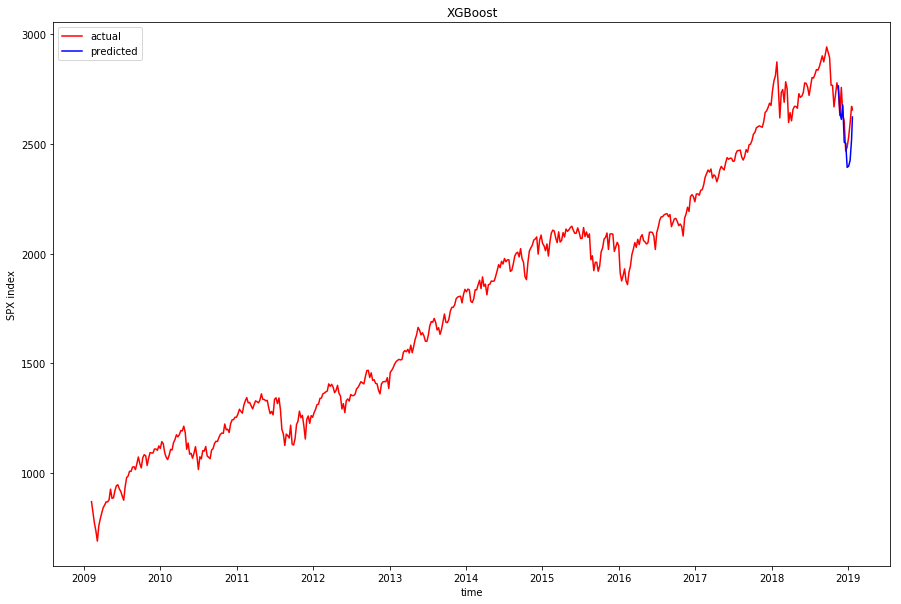

In [14]:
fig=plt.figure(figsize=(15,10))
plt.title('XGBoost')
plt.plot(y,'r',label='actual')
plt.legend('actual')
plt.plot(pred,'b',label='predicted')
plt.legend(loc='upper left')
plt.xlabel('time')
plt.ylabel('SPX index')
fig.savefig('XGBoost.png')
# может спрогнозировать остальные данные и подставить оценки в нашу модель???

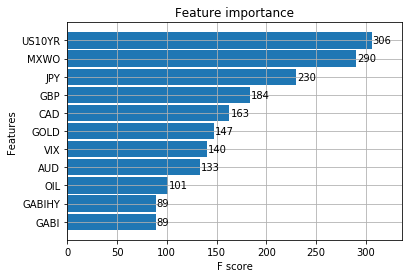

In [15]:
ax = plot_importance(gbm, height=0.9)
ax.figure.savefig('feature_importanct.png', bbox_inches = 'tight')

                                    **Now try hyperparameters tuning**

In [16]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)

In [19]:
params={
    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'n_estimators': range(500,1000,100)
}

param_comb=10
# estimating only 10 combinations
xgb = xgb.XGBRegressor()

In [36]:
random_search=RandomizedSearchCV(xgb, param_distributions=params,n_iter=param_comb, 
                                 scoring='neg_mean_squared_error',cv=tscv.split(X_train))

In [37]:
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000000000B662390>,
          error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2), 'n_estimators': range(500, 1000, 100)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [58]:
print('Best score \n', random_search.best_score_,
      '\n \n Best parameters \n', random_search.best_params_,
      '\n \n Best estimator \n', random_search.best_estimator_)

Best score 
 -142028.53376088926 
 
 Best parameters 
 {'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.3} 
 
 Best estimator 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=9, min_child_weight=3, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [51]:
np.sqrt(mean_squared_error(y_test,predictions)) 
# best estimator of tuned model
# rmse has dropped by 20.3

79.75458726340497

In [52]:
pred=pd.Series(predictions, index=y_test.index)

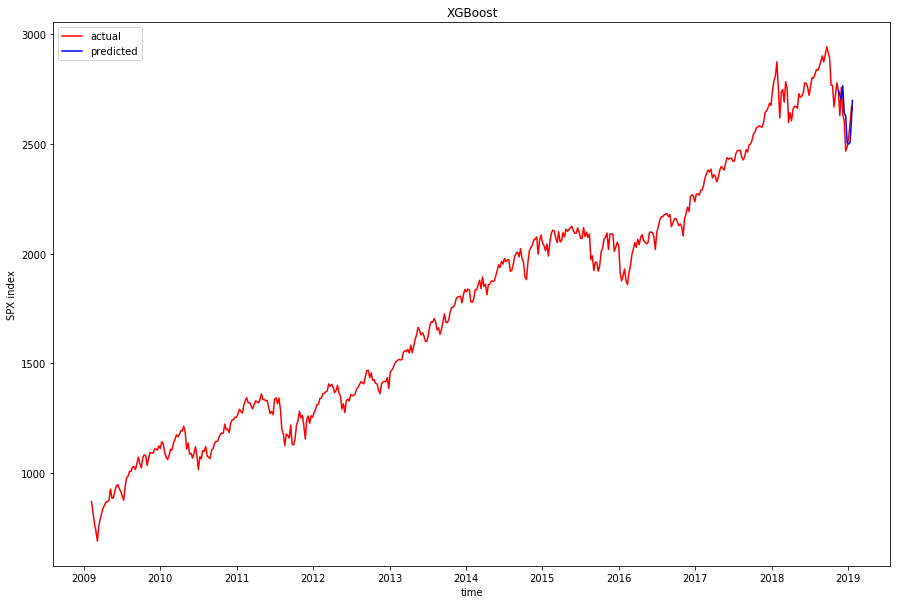

In [53]:
fig=plt.figure(figsize=(15,10))
plt.title('XGBoost')
plt.plot(y,'r',label='actual')
plt.legend('actual')
plt.plot(pred,'b',label='predicted')
plt.legend(loc='upper left')
plt.xlabel('time')
plt.ylabel('SPX index')
fig.savefig('XGBoost.png')
# может спрогнозировать остальные данные и подставить оценки в нашу модель???

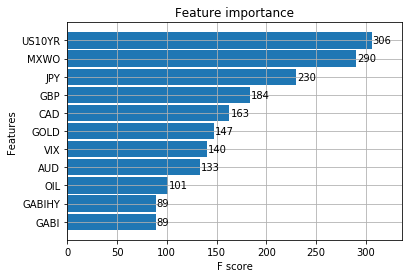

In [54]:
ax = plot_importance(gbm, height=0.9)
ax.figure.savefig('feature_importanct.png', bbox_inches = 'tight')
# same